## Import Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils import data
import numpy as np

import librosa as li
import librosa.display as display
import scipy.io.wavfile as wavfile
import IPython.display as ipd
import sounddevice as sd

import os
import matplotlib.pyplot as plt

import descriptors
from synth.ddsp_components import HarmonicSynth
from core import resample

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare the Dataset

In [3]:
# Init Dataset parameters
batch_size_train = 32
batch_size_test = 32

In [4]:
# Define our own Dataset class
class AudioDataset(data.Dataset):
    def __init__(self, data_env, data_spec, data_sr):
        super(AudioDataset, self).__init__()
        self.data_env = data_env
        self.data_spec = data_spec
        self.data_sr = data_sr

    def __getitem__(self, index):
        return self.data_env[index], self.data_spec[index], self.data_sr[index]
    
    def __len__(self):
        return len(self.data_env)

In [5]:
# Init dictionary
dict_r = np.load('data_dict.npy', allow_pickle=True).item()
n_samples = len(dict_r['file_name'])
train_audio = np.zeros([n_samples, 48000])
train_sr = np.zeros(n_samples)
train_env = np.zeros([n_samples, 2, 750])

# Get spectrograms and samplerate from samples
i = 0
for name in dict_r['file_name']:
    x, sr = li.core.load(name)
    x = li.resample(x, sr, 16000)
    train_audio[i,:] = x
    train_sr[i] = sr
    i+=1

# Get envelopes from samples
i = 0
for sample in dict_r['env']:
    train_env[i,:,:] = sample
    i+=1

train_env[:,1,:] = np.log(train_env[:,1,:])
MAX1 = np.max(train_env[:,0,:])
MAX2 = np.max(train_env[:,1,:])
train_env[:,0,:] /= MAX1
train_env[:,1,:] /= MAX2
train_dataset = AudioDataset(torch.from_numpy(train_env), torch.from_numpy(train_audio), torch.from_numpy(train_sr))
test_dataset = train_dataset

print(train_env.shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size_train, shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size_test, shuffle=True, drop_last=True)

(279, 2, 750)


### Test on some examples

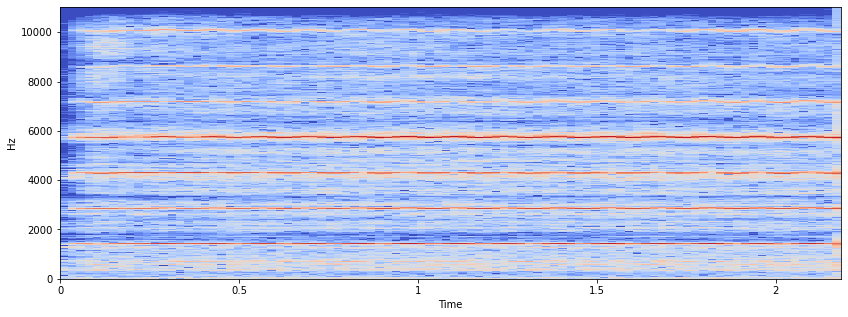

In [6]:
examples = enumerate(test_loader)
index, (ex_env, ex_audio, ex_sr) = next(examples)

X = abs(li.stft(ex_audio[0].numpy()))
Xdb = li.amplitude_to_db(X)
plt.figure(figsize=(14, 5))
display.specshow(Xdb, sr=ex_sr[0].numpy(), x_axis='time', y_axis='hz')

## Building the Network

In [7]:
# Define MLP module
class MLP(nn.Module):
    def __init__(self, in_size, hidden_size, n_layers):
        super(MLP, self).__init__()
        mlp_net = []
        for i in range(n_layers):
            if (i == 0):
                mlp_net.append(nn.Linear(in_size, hidden_size)) # equivalent to Dense in keras
            else:
                mlp_net.append(nn.Linear(hidden_size, hidden_size)) # equivalent to Dense in keras
            mlp_net.append(nn.LayerNorm(hidden_size))
            mlp_net.append(nn.ReLU())
        self.layers = nn.Sequential(*mlp_net)
        
    def forward(self, x):
        x = self.layers(x)
        return x

# Define Decoder
class DDSP(nn.Module):
    def __init__(self, hidden_size, n_harmonics, n_bands, n_layers, sampling_rate, block_size):
        super(DDSP, self).__init__()
        self.register_buffer("sampling_rate", torch.tensor(sampling_rate))
        self.register_buffer("block_size", torch.tensor(block_size))
        
        self.MLP_f0 = MLP(1, hidden_size, n_layers)
        self.MLP_loudness = MLP(1, hidden_size, n_layers)
        self.GRU = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.MLP_out = MLP(hidden_size + 2, hidden_size, n_layers)
        
        self.harm_linear = nn.Linear(hidden_size, n_harmonics + 1)
        self.noise_linear = nn.Linear(hidden_size, n_bands)

    def forward(self, f0, loudness):
        
        x1 = self.MLP_f0(f0)
        x2 = self.MLP_loudness(loudness)
        x = torch.cat([x1, x2], -1)
        x = self.GRU(x)[0]
        x = torch.cat([x, f0, loudness], -1)
        x = self.MLP_out(x)
        
        harm_param = self.harm_linear(x) # additive synth parameters
        noise_param = self.noise_linear(x) # filtered noise synth parameters
        
        # Resampling to get audio of the same size
        harm_param = resample(harm_param, self.block_size.item())
        f0_resampled = resample(f0, self.block_size.item())[:,:,0]

        # Extract amplitude total and harmonic distribution from additive synth parameters
        total_amp = harm_param[..., 0]
        harm_amps = harm_param[..., 1:]
        harm_amps = f.normalize(harm_amps, p=1, dim=2) # normalize harmonic distribution

        # Synthesize signal with harmonic additive synthesizer
        harmonic_synth = HarmonicSynth(self.sampling_rate)
        audio_harmonic = harmonic_synth.get_signal(f0_resampled, total_amp, harm_amps)

        #filtered_noise = FilteredNoise(self.sampling_rate)
        #audio_noise = filtered_noise.get_signal(noise_param)

        # Combine both signals to get final signal
        #audio = audio_harmonic + audio_noise
        audio = audio_harmonic
        audio /= np.abs(audio.detach().numpy()).max() # normalize audio

        return audio

## Training the Model

In [10]:
# Init model parameters
sampling_rate = 16000
block_size = 64
hidden_size = 512
n_harmonics = 5
n_bands = 20
n_layers = 3
n_epochs = 100
log_interval = 1
learning_rate = 0.0001
alpha = 1.0
fft_sizes = [2048, 1024, 512, 256, 128, 64]

# Keep track of loss evolution for the train and the test dataset
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

# Init network and optimizer
network = DDSP(hidden_size, n_harmonics, n_bands, n_layers, sampling_rate, block_size).to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [11]:
# Def train loop
def train(epoch):
    network.train()
    for batch_idx, (data_env, data_audio, data_sr) in enumerate(train_loader):
        optimizer.zero_grad()

        # Compute audio from pitch and loudness
        f0 = data_env[:,0,:].float().unsqueeze(-1).to(device)
        loudness = data_env[:,1,:].float().unsqueeze(-1).to(device)
        x = network(f0, loudness) # audio synthesized from parameters
        y = data_audio.to(device) # original audio
        
        # Compute total loss
        loss = 0
        for i in range(0,len(fft_sizes)):
            
            # Compute spectrogram from audio
            X = abs(torch.stft(x, fft_sizes[i], return_complex = True))
            Y = abs(torch.stft(y, fft_sizes[i], return_complex = True))
            
            # Compute loss for each fft size
            loss += (Y - X).abs().mean()
            loss += alpha * (torch.log(Y+1e-7) - torch.log(X+1e-7)).abs().mean()

        # Backprop
        network.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data_sr), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), "./results/model.pth")
            torch.save(optimizer.state_dict(), "./results/optimizer.pth")

In [12]:
# Training of the network
for epoch in range(1, n_epochs + 1):
    train(epoch)

C:\Users\Chapa\Anaconda3\lib\site-packages\torch\functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Train Epoch: 1 [0/279 (0%)]	Loss: 22.069074
Train Epoch: 1 [32/279 (12%)]	Loss: 20.978722
Train Epoch: 1 [64/279 (25%)]	Loss: 23.237690
Train Epoch: 1 [96/279 (38%)]	Loss: 24.077485
Train Epoch: 1 [128/279 (50%)]	Loss: 23.230319
Train Epoch: 1 [160/279 (62%)]	Loss: 22.577137
Train Epoch: 1 [192/279 (75%)]	Loss: 21.897278
Train Epoch: 1 [224/279 (88%)]	Loss: 22.193194


## Test the Model

In [34]:
examples = enumerate(test_loader)
index, (ex_env, ex_audio, ex_sr) = next(examples)

f0 = ex_env[:,0,:].float().unsqueeze(-1).to(device)
loudness = ex_env[:,1,:].float().unsqueeze(-1).to(device)
x = network(f0, loudness) # audio synthesized from parameters

# Play synthesized audio
audio0_synth = x[0,...].cpu().detach().numpy()
ipd.Audio(audio0_synth, rate=16000)

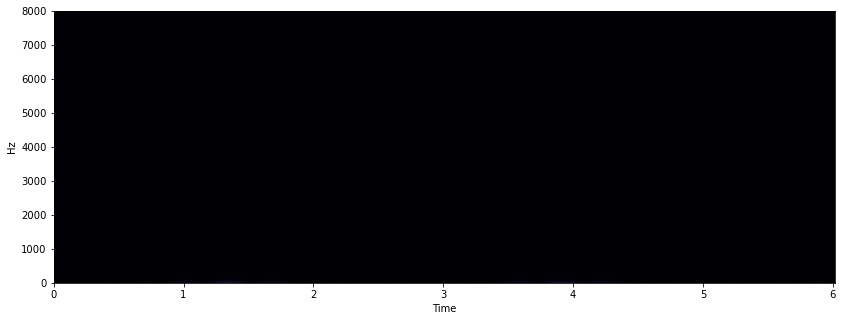

In [35]:
# Compute spectrogram from synthesized audio
X = abs(torch.stft(x, 1024, return_complex = True))
plt.figure(figsize=(14, 5))
display.specshow(X[0,...].cpu().detach().numpy(), sr=16000, x_axis='time', y_axis='hz')

In [36]:
# Play original audio
audio0_orig = ex_audio[0,...].cpu().detach().numpy()
ipd.Audio(audio0_orig, rate=16000)

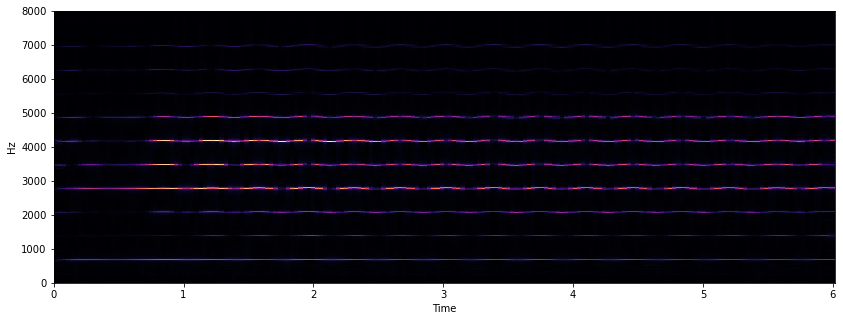

In [37]:
# Compute spectrogram from original audio
Y = abs(torch.stft(ex_audio, 1024, return_complex = True))
plt.figure(figsize=(14, 5))
display.specshow(Y[0,...].cpu().detach().numpy(), sr=16000, x_axis='time', y_axis='hz')